# Lab 07

### <span style="color:chocolate"> Submission requirements </span>

Your homework will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Step 1: Import libraries

In [76]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path

^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 2: Read data

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the `load_data` function according to the following guidelines:
- to read label and image names: use the os library (in particular the os.listdir() and os.path.join() methods)
- to load an image: use the load_image() method (see list of imported libraries)
- to transform images to arrays: use the img_to_array() method (see list of imported libraries)

In [77]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    ## load images and labels
    # FILL IN CODE HERE #
    images = []
    labels = []
    for folder in os.listdir(path_to_data):
        label_dir = os.path.join(path_to_data, folder)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                if file_path.lower().endswith('.jpg'):
                    image = load_img(file_path, target_size=(64,64))
                    image_array = img_to_array(image)
                    images.append(image_array)
                    labels.append(folder)
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [78]:
# Load images and labels. Print shapes
images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 3: Inspect data

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

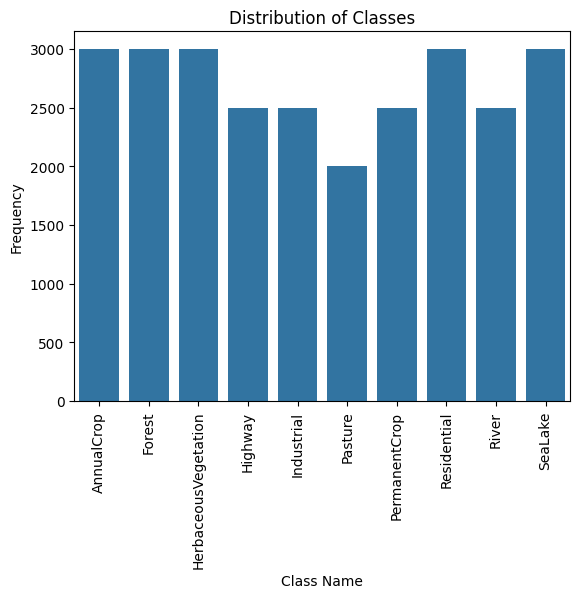

In [79]:
# FILL IN CODE HERE # 
label_counts = np.unique(labels, return_counts=True)
sns.barplot(x=label_counts[0], y=label_counts[1])
plt.xlabel('Class Name')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Classes')
plt.show()

Comment on class balance: The classes are not perfectly balanced. AnnualCrop, Forest, HerbaceousVegetation, Residential, and SeaLake each have 3,000 samples, which is great. But Highway, Industrial, PermanentCrop, and River only have 2,500 samples, and Pasture only has 2,000 samples.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

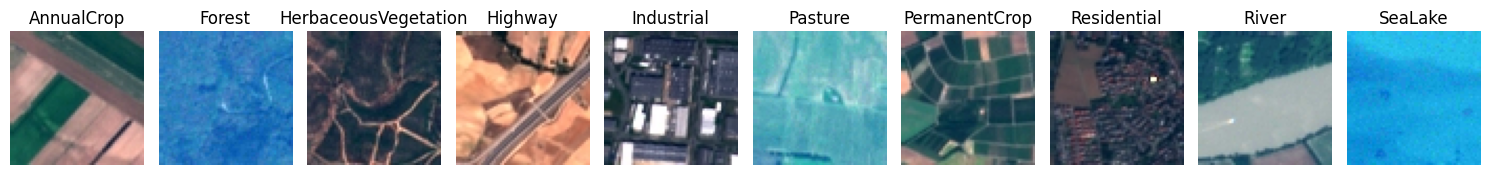

In [80]:
# FILL IN CODE HERE #
np.random.seed(0)
images_sample = np.random.rand(10,64,64,3)
unique_labels, indices = np.unique(labels, return_index=True)
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15,5))
for ax, index, label in zip(axes, indices, unique_labels):
    tn = array_to_img(images[index])
    ax.imshow(tn)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

Most confused land classes: Industrial and Residential look like they may be confused. PermanentCrop and AnnualCrop also look like they may be confused, both with each other and potentially with HerbaceousVegetation.

---
### Step 4: Preprocess data

Encode labels

In [81]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the `split_data` function according to the following guidelines:
- shuffle images and labels before spliting the data
- use a 60/20/20 split

In [82]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    # FILL IN CODE HERE #
    n_samples = images.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]
    
    # create data splits
    # FILL IN CODE HERE #
    train = int(n_samples * split[0])
    val = train + int(n_samples * split[1])
    X_train = shuffled_images[:train]
    y_train = shuffled_labels[:train]
    X_val = shuffled_images[train:val]
    y_val = shuffled_labels[train:val]
    X_test = shuffled_images[val:]
    y_test = shuffled_labels[val:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [83]:
# Define splits
split = (0.6, 0.2, 0.2)

# Create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# Print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the `data_preprocessing()` function according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module).
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels.
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [84]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        # adjust brightness
        X_augm = tf.map_fn(lambda x: tf.image.adjust_brightness(x, DELTA), X) # FILL IN CODE HERE #

        # adjust contrast
        X_augm = tf.map_fn(lambda x: tf.image.adjust_contrast(x, CONTRAST_FACTOR), X_augm) # FILL IN CODE HERE #

        # random flip
        X_augm = tf.map_fn(lambda x: tf.image.random_flip_left_right(x), X_augm) # FILL IN CODE HERE #

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0) # FILL IN CODE HERE #

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm], axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # rescale image by dividing each pixel by 255.0 
    # FILL IN CODE HERE #
    X = X / 255.
    
    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): Augmenting image data can increase both size and diversity, while also allowng for better generalizatin when slight modifications to images are made to copied/augmented image pixels.

In [85]:
# Apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# Print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [86]:
# Compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# Reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# Print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the RandomForestClassifier class available in the sklearn.ensemble module
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

In [87]:
### YOUR CODE HERE ###
model = ensemble.RandomForestClassifier(n_estimators=2,
                                        n_jobs=1,
                                        random_state=7,
                                        max_depth=8)
model.fit(X_train_re, y_train)
y_train_pred = model.predict(X_train_re)
y_val_pred = model.predict(X_val_re)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Val Accuracy:", accuracy_score(y_val, y_val_pred))

Train Accuracy: 0.48169753086419753
Val Accuracy: 0.44481481481481483


In [89]:
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

[[237  13  85   9  18  25  69  63  36  30]
 [  0 520   2   0   0  32   0   4  10  41]
 [ 41  29 225  12  18  31  74 120  32  24]
 [ 43  42  76  30  18  55  34 122  67  16]
 [ 71   0  33   1 223  10  42 131   8   3]
 [  1  41  53   5   0 200   2  35  30  36]
 [136   5 103   6  14  16 104  90  12   5]
 [ 37   0 123   8  39  29  50 287  21  13]
 [ 13  90  33  19   2  49   8  72 166  41]
 [  0  96   4   0   3  28   0  24  16 410]]


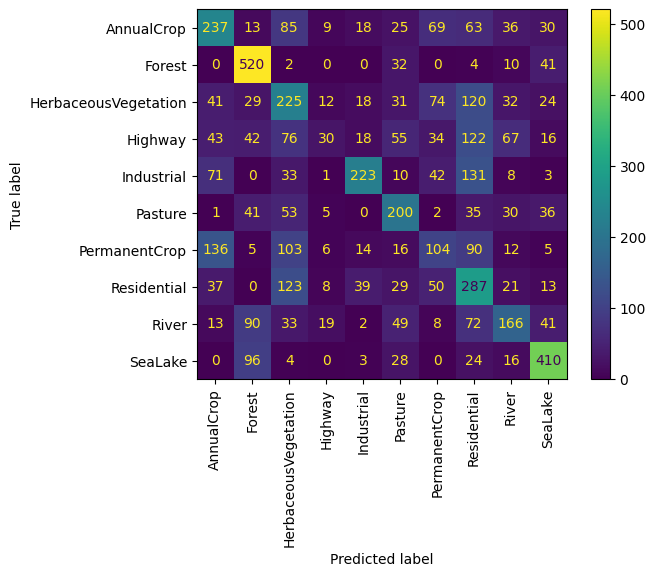

In [91]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=encoder.classes_)
fig, ax = plt.subplots()
cm_disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

Comment on model accuracy on training vs. validation data: Training Accuracy is sligthly higher than Validation Accuracy. This is expected, as our models will tend to at least slightly overfit to the training data.

Does the model generalize well?: Yes, the model generalizes relatively well based on our validation set. The accuracy scores are relatively close, with Validation Accuracy only ~4% lower than Training Accuracy.

Comment on the classes that the model confuses the most: The model consuses AnnualCrop with PermanentCrop, HerbaceousVegetation with Residential, and Residential with Industrial the most.

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). The model should also generalize well (the performance difference between the training and validation sets should be at most 10%). Also, be sure to follow these guidelines: 
    
- Use the RandomForestClassifier or the GradientBoostingClassifier available in the sklearn.ensemble module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Does your model generalize well?
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

In [123]:
rf_clf2 = ''
### YOUR CODE HERE ###
model = ensemble.RandomForestClassifier(n_estimators=50,
                                        n_jobs=50,
                                        random_state=7,
                                        max_depth=8)
model.fit(X_train_re, y_train)
y_train_pred = model.predict(X_train_re)
y_val_pred = model.predict(X_val_re)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Val Accuracy:", accuracy_score(y_val, y_val_pred))

Train Accuracy: 0.6361728395061729
Val Accuracy: 0.5407407407407407


How your implementation is different compared to the baseline classifier: I increased the number of trees/estimators to 50. I also increased the number of jobs to help the model train faster by processing jobs in parallel.

Comment on training vs. validation performance relative to baseline model: While both train and validation accuracy have improved over the baseline model, the new model is not generalizing as well. However, accuracy has improved by ~10% and the difference in accuracy between train and validation in the new model remains less than 2%.

Does the model generalize well? No, my updated model does not generalize as well. The Validation Accuracy is now ~9% lower than the Training Accuracy.

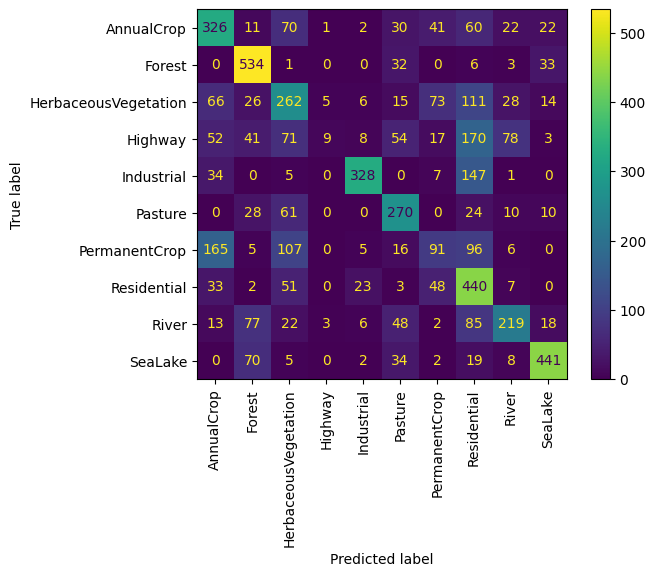

In [124]:
cm = confusion_matrix(y_val, y_val_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=encoder.classes_)
fig, ax = plt.subplots()
cm_disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

Comment on the classes the model confuses the most relative to the baseline: The new model confuses Residential with Highway, AnnualCrop with PermanentCrop, and Residential with Industrial the most.

---
### Step 6: Evaluation (on test data)

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the validation set?

In [125]:
### YOUR CODE HERE ###
y_test_pred = model.predict(X_test_re)
print("Val Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Val Accuracy: 0.5407407407407407
Test Accuracy: 0.5351851851851852


Comment on test set accuracy vs. validation set accuracy: The test set accuracy and validation set accuracy are essentially the same. Test set accuracy is ~1% lower than validation set accuracy.

---
### Step 7: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

No, I would generally not recommend a Decision Forest for land cover classification. The reason for this is that image classification benefits significantly from the differences / relationships between features (in this case, pixels). Models like decision trees do not produce these parameters naturally.

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

I would recommend a convolutional neural network (CNN). The convolutions in a CNN generate parameters that refelect the differences and other relationships between the original pixels of the image. This allows for the layers of the neural network more broadly to identify edges and other meaningful components of an image that help to classify it.

#### <span style="color:chocolate"> Bonus Exercise (20 points) </span>

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [106]:
### YOUR CODE HERE ###
from tensorflow.keras import layers, models

def create_model(input_shape=(64,64,3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),

        layers.Flatten(),

        layers.Dense(64, activation='relu'),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [107]:
tf.keras.backend.clear_session()
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [108]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
1013/1013 [==============================] - 26s 26ms/step - loss: 1.2079 - accuracy: 0.5484 - val_loss: 0.9006 - val_accuracy: 0.6817
Epoch 2/10
1013/1013 [==============================] - 26s 26ms/step - loss: 0.7655 - accuracy: 0.7246 - val_loss: 0.7500 - val_accuracy: 0.7291
Epoch 3/10
1013/1013 [==============================] - 26s 26ms/step - loss: 0.6010 - accuracy: 0.7860 - val_loss: 0.6621 - val_accuracy: 0.7554
Epoch 4/10
1013/1013 [==============================] - 26s 26ms/step - loss: 0.4745 - accuracy: 0.8319 - val_loss: 0.7291 - val_accuracy: 0.7402
Epoch 5/10
1013/1013 [==============================] - 26s 26ms/step - loss: 0.3929 - accuracy: 0.8614 - val_loss: 0.5044 - val_accuracy: 0.8194
Epoch 6/10
1013/1013 [==============================] - 26s 26ms/step - loss: 0.3144 - accuracy: 0.8894 - val_loss: 0.6342 - val_accuracy: 0.7957
Epoch 7/10
1013/1013 [==============================] - 26s 26ms/step - loss: 0.2760 - accuracy: 0.9031 - val_loss: 0.5404 -

In [109]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy:  {test_acc}')

169/169 - 1s - loss: 0.4776 - accuracy: 0.8528 - 1s/epoch - 8ms/step
Test accuracy:  0.8527777791023254


#### Discussion - Did the model perform / generalize well?

As indicated above, a CNN performs better even without significant hyperparamater tuning on image classification problems. In this case, final test accuracy of ~85% was achieved.

The model did not generalize exceptionally well though. Train accuracy was ~94%, while validation accuracy was only ~84%, and test accuracy was only ~85%. It may be able to improve on generalization of this CNN with more hyperparameter tuning, though.